In [22]:
import os
import h5py
import gvar   as gv
import numpy  as np
import pandas as pd
from   matplotlib import pyplot as plt

def RatioFileString(name,ts,h,hss,q,l,p):
    return f'{name}T{ts}{h}_RW_{hss}_rot_rot{q}{l}_p{p}'

def format(v):
    return gv.gvar(
        v.mean(axis=0),
        v.std(axis=0) * np.sqrt(v.shape[0]-1)
    )

def plot(v,**kwargs):
    plt.errorbar(
        np.arange(len(v)),
        gv.mean(v),
        gv.sdev(v),
        fmt='.',
        **kwargs
    )

def jkCorr(data, bsize=1):
    if bsize==0:
        return data
    else:
        rData = (data.shape[0]//bsize)
        nData = rData*bsize
        dIn   = data[0:nData,:]

        avg   = dIn.mean(axis=0)

        base  = dIn.sum(axis=0) # avg * nData

        dOut  = dIn * 0.0

        for cf in range(rData):
            pvg = dIn[cf*bsize:(cf+1)*bsize,:].sum(axis=0)
            dOut[cf,:] = (base - pvg)/(nData - bsize)

        return dOut[:rData,:]

In the following cell import `FnalHISQMetadata` module giving the correct path

In [23]:
from b2heavy.FnalHISQMetadata import params # change

ens = 'Coarse-1'
mom = '100'
jk  = 11

mdata = params(ens)
Ta,Tb = mdata['hSinks']

heavy = '_k' + mdata['kBStr']
light = '_k' + mdata['kDStr']
qq    = '_m' + mdata['mlStr']

data = h5py.File(f'/Users/pietro/code/data_analysis/BtoD/Alex/Ensembles/FnalHISQ/a0.12/{mdata["hdf5File2"]}')
data = data['data']

$$
    X_V(\mathbb p _\perp,t,T) = \frac{C_{B_{1S}\rightarrow D_a^*}^{V_j}(\mathbb p _\perp ,t,T)}{C_{B_{1S}\rightarrow D_a^*}^{A_j}(\mathbb p _\perp ,t,T)}
$$ 

## Reading

in the following cells we read the data from the archive and we build the uncorrected ratio for each smearing and each sink time and we put it in a dictionary `data_read`

------------- tsink = 12 --------- smr = '1S' -------------------
P5_V3_V2_T12_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p100
P5_V2_V3_T12_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p100
P5_A2_V2_T12_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p100
P5_A3_V3_T12_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p100
------------- tsink = 13 --------- smr = '1S' -------------------
P5_V3_V2_T13_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p100
P5_V2_V3_T13_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p100
P5_A2_V2_T13_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p100
P5_A3_V3_T13_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p100
------------- tsink = 12 --------- smr = 'RW' -------------------
P5_V3_V2_T12_k0.08574_RW_RW_rot_rot_m0.00507_k0.12201_p100
P5_V2_V3_T12_k0.08574_RW_RW_rot_rot_m0.00507_k0.12201_p100
P5_A2_V2_T12_k0.08574_RW_RW_rot_rot_m0.00507_k0.12201_p100
P5_A3_V3_T12_k0.08574_RW_RW_rot_rot_m0.00507_k0.12201_p100
------------- tsink = 13 --------- smr = 'RW' -------------------
P5_V3_V2_T13_k0.08574_RW_RW_

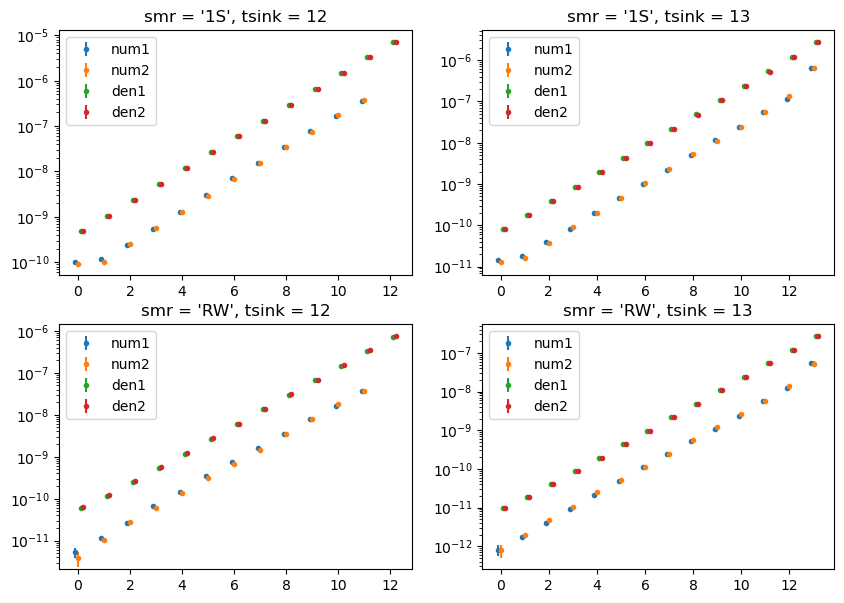

In [71]:
fig,ax = plt.subplots(2,2,figsize=(10,7))

data_read = {}
for i,smr in enumerate(['1S','RW']):
    data_read[smr] = {}
    for j,tsink in enumerate([Ta,Tb]):
        print(f'------------- {tsink = } --------- {smr = } -------------------')

        # Numerator 1 ===========================================================
        corr = RatioFileString('P5_V3_V2_',tsink,heavy,smr,qq,light,mom)
        num1 = jkCorr(-data[corr][:,:(tsink+1)], bsize=jk)
        print(corr)

        # Numerator 2 ===========================================================
        corr = RatioFileString('P5_V2_V3_',tsink,heavy,smr,qq,light,mom)
        num2 = jkCorr(data[corr][:,:(tsink+1)], bsize=jk)
        print(corr)

        # Denominator 1 ===========================================================
        corr = RatioFileString('P5_A2_V2_',tsink,heavy,smr,qq,light,mom)
        den1 = jkCorr(-data[corr][:,:(tsink+1)], bsize=jk)
        print(corr)

        # Denominator 2 ===========================================================
        corr = RatioFileString('P5_A3_V3_',tsink,heavy,smr,qq,light,mom)
        den2 = jkCorr(-data[corr][:,:(tsink+1)], bsize=jk)
        print(corr)

        data_read[smr][tsink] = ((num1 + num2)/2) / ((den1 + den2)/2)





        v = format(num1)
        ax[i,j].errorbar(np.arange(len(v))-0.1,gv.mean(v),gv.sdev(v),fmt='.',label='num1',color='C0')
        v = format(num2)
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='num2',color='C1')
        v = format(den1)
        ax[i,j].errorbar(np.arange(len(v))+0.1,gv.mean(v),gv.sdev(v),fmt='.',label='den1',color='C2')
        v = format(den2)
        ax[i,j].errorbar(np.arange(len(v))+0.2,gv.mean(v),gv.sdev(v),fmt='.',label='den2',color='C3')

        ax[i,j].set_title(f'{smr = }, {tsink = }')
        ax[i,j].set_yscale('log')
        ax[i,j].legend()

-------------- tsink = 12 smr = '1S' --------------
[0.193(16) 0.1024(35) 0.1036(36) 0.1052(40) 0.1086(37) 0.1126(37)
 0.1172(36) 0.1165(34) 0.1160(35) 0.1148(35) 0.1151(35) 0.1123(32)
 -0.146(19)]
13
-------------- tsink = 13 smr = '1S' --------------
[0.168(19) 0.0981(45) 0.1003(45) 0.1008(45) 0.1020(46) 0.1052(46)
 0.1068(46) 0.1076(44) 0.1094(44) 0.1054(49) 0.1018(41) 0.1041(37)
 0.1037(40) 0.234(21)]
14
-------------- tsink = 12 smr = 'RW' --------------
[0.074(22) 0.0933(52) 0.1079(49) 0.1143(47) 0.1171(47) 0.1189(44)
 0.1157(47) 0.1137(46) 0.1145(43) 0.1153(42) 0.1143(37) 0.1095(38)
 -0.060(22)]
13
-------------- tsink = 13 smr = 'RW' --------------
[0.083(28) 0.0987(79) 0.1090(73) 0.1117(73) 0.1172(69) 0.1179(62)
 0.1156(64) 0.1132(56) 0.1142(51) 0.1083(55) 0.1039(52) 0.1087(54)
 0.1104(50) 0.195(23)]
14


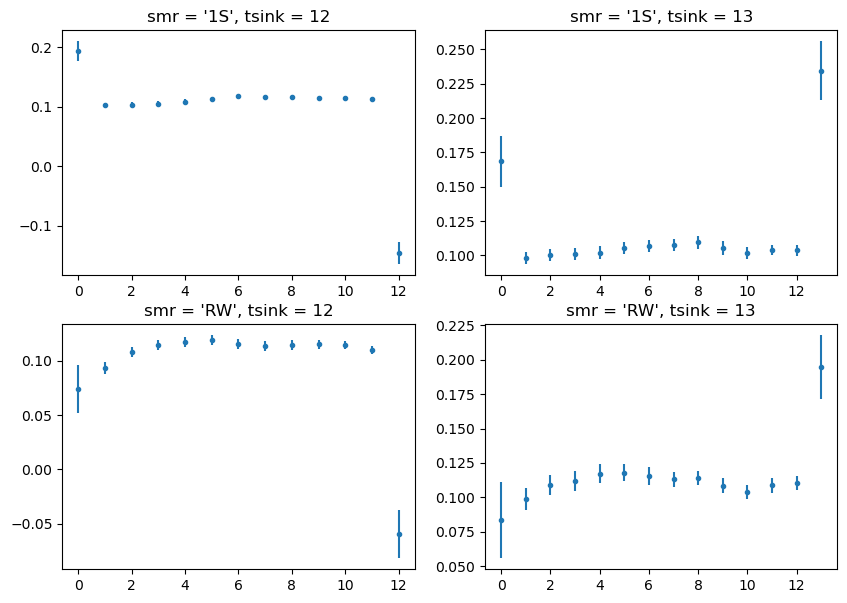

In [72]:
fig,ax = plt.subplots(2,2,figsize=(10,7))
for i,smr in enumerate(data_read):
    for j,tsink in enumerate(data_read[smr]):
        print(f'-------------- {tsink = } {smr = } --------------')
        print(format(data_read[smr][tsink]))
        print(len(format(data_read[smr][tsink])))

        v = format(data_read[smr][tsink])
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='num1',color='C0')
        ax[i,j].set_title(f'{smr = }, {tsink = }')

In [73]:
data_corr = {smr: {} for smr in data_read}

for smr in data_read:
    for tsink in data_read[smr]:
        data_corr[smr][tsink] = data_read[smr][tsink][:,:Ta+1]
        print(f'-------------- {tsink = } {smr = } --------------')
        print(format(data_corr[smr][tsink]))

        print(data_corr[smr][tsink].shape)

-------------- tsink = 12 smr = '1S' --------------
[0.193(16) 0.1024(35) 0.1036(36) 0.1052(40) 0.1086(37) 0.1126(37)
 0.1172(36) 0.1165(34) 0.1160(35) 0.1148(35) 0.1151(35) 0.1123(32)
 -0.146(19)]
(90, 13)
-------------- tsink = 13 smr = '1S' --------------
[0.168(19) 0.0981(45) 0.1003(45) 0.1008(45) 0.1020(46) 0.1052(46)
 0.1068(46) 0.1076(44) 0.1094(44) 0.1054(49) 0.1018(41) 0.1041(37)
 0.1037(40)]
(90, 13)
-------------- tsink = 12 smr = 'RW' --------------
[0.074(22) 0.0933(52) 0.1079(49) 0.1143(47) 0.1171(47) 0.1189(44)
 0.1157(47) 0.1137(46) 0.1145(43) 0.1153(42) 0.1143(37) 0.1095(38)
 -0.060(22)]
(90, 13)
-------------- tsink = 13 smr = 'RW' --------------
[0.083(28) 0.0987(79) 0.1090(73) 0.1117(73) 0.1172(69) 0.1179(62)
 0.1156(64) 0.1132(56) 0.1142(51) 0.1083(55) 0.1039(52) 0.1087(54)
 0.1104(50)]
(90, 13)


## Exponentials + smoothening

$$
\bar R_{A_1}(t,T) = \frac{1}{2}R_{A_1}(t,T) + \frac{1}{4}R_{A_1}(t,T+1) + \frac{1}{4}R_{A_1}(t+1,T+1)
$$

In [74]:
barR = {}
barR['1S'] = data_corr['1S'][Ta  ]/2     +     data_corr['1S'][Tb]/4  +  np.roll(data_corr['1S'][Tb],-1,axis=1)/4 
barR['RW'] = data_corr['RW'][Ta  ]/2     +     data_corr['RW'][Tb]/4  +  np.roll(data_corr['RW'][Tb],-1,axis=1)/4 

In [75]:
for sm in ['1S','RW']:
    print(f'------------ {sm = } -------------')
    print(format(barR[sm]))

------------ sm = '1S' -------------
[0.1633(99) 0.1008(29) 0.1021(29) 0.1033(32) 0.1061(29) 0.1093(29)
 0.1122(30) 0.1125(29) 0.1117(30) 0.1092(29) 0.1090(26) 0.1081(25)
 -0.005(10)]
------------ sm = 'RW' -------------
[0.082(14) 0.0986(45) 0.1091(44) 0.1144(41) 0.1173(37) 0.1178(37)
 0.1150(40) 0.1137(37) 0.1129(36) 0.1107(35) 0.1103(34) 0.1096(34)
 0.019(13)]


<ErrorbarContainer object of 3 artists>

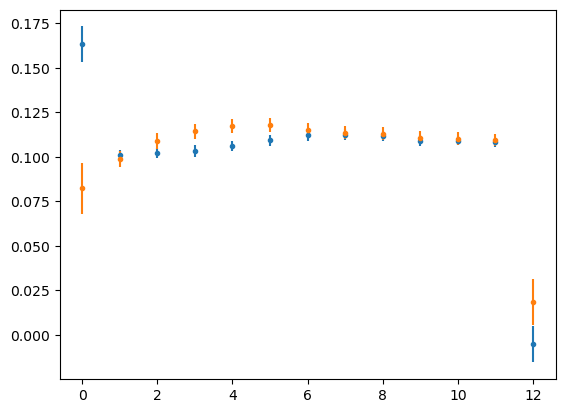

In [76]:
y1S = format(barR['1S'])
yRW = format(barR['RW'])
x   = np.arange(len(y1S))

plt.errorbar(x,gv.mean(y1S),gv.sdev(y1S),fmt='.')
plt.errorbar(x,gv.mean(yRW),gv.sdev(yRW),fmt='.')

# `CUSTOM`

In [77]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object
from b2heavy.ThreePointFunctions.corr3pts   import BINSIZE

In [78]:
# This cell has only to be evaluated if next python cell is not

from b2heavy.ThreePointFunctions.types3pts import ratio_prerequisites

# frm = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/lattice24_old'
frm = '/Users/pietro/Desktop/lattice24/0.25/corr2_3'
req = ratio_prerequisites(ens,'XV',mom,readfrom=frm)
req

{'E0': 1.0945168103425729,
 'm0': 1.0809632444217314,
 'Z0': {'1S': 4.822281482026914, 'd': 0.04150728444106053},
 'Zpar': {'1S': 4.206996648477069, 'd': 0.04197877610257331},
 'Zbot': {'1S': 3.9710649225139107, 'd': 0.039325085747476805},
 'Zp': {'1S': None, 'd': None},
 'wrecoil': 1.0125384151503616,
 'jk': False}

In [85]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
io = RatioIO(ens,'XV',mom,PathToDataDir=DATA_DIR)
robj = RatioFitter(
    io,
    jkBin     = BINSIZE[ens],
    smearing  = ['1S','RW'],
    **req
)

In [86]:
x,rr = robj.format()
r1S = rr['1S']
rRW = rr['RW']

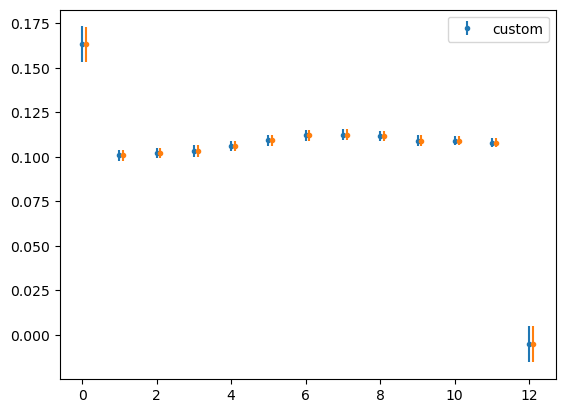

In [87]:
plt.errorbar(x,gv.mean(r1S),gv.sdev(r1S),fmt='.',label='custom')
plt.errorbar(x+0.1,gv.mean(y1S),gv.sdev(y1S),fmt='.')
plt.legend()

<ErrorbarContainer object of 3 artists>

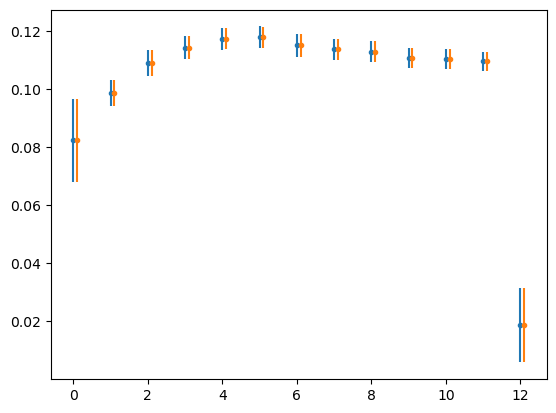

In [88]:
plt.errorbar(x    ,gv.mean(rRW),gv.sdev(rRW),fmt='.')
plt.errorbar(x+0.1,gv.mean(yRW),gv.sdev(yRW),fmt='.')